In [156]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import *

Используя библиотеку PyTorch, решите задачу регрессии. Разделите набор данных
на обучающее и тестовое множество. Выполните предобработку данных.
Отобразите графики значений функции потерь и метрики на обучающем
множестве. Рассчитайте значение метрики на тестовом множестве.

In [157]:
df = pd.read_csv('dataset/regression/concrete.csv')
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [158]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["strength"]), df["strength"], random_state=42, train_size=0.7)

In [159]:
print(X_train.shape)
print(y_train.shape)

(721, 8)
(721,)


In [160]:
# scaler = MinMaxScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train))
# X_train

In [161]:
class ConcreteDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_tensor = torch.tensor(self.X.iloc[idx , :]).to(torch.float32)
        y_tensor = torch.tensor(self.y.iloc[idx]).to(torch.float32)

        return x_tensor, y_tensor

In [162]:
train_dataset = ConcreteDataset(X_train, y_train)
test_dataset = ConcreteDataset(X_test, y_test)

In [163]:
train_dataset[0]

(tensor([ 194.7000,    0.0000,  100.5000,  165.6000,    7.5000, 1006.4000,
          905.9000,   28.0000]),
 tensor(25.7200))

In [164]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [165]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [166]:
class MultipleRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultipleRegression, self).__init__()
        self.layer1 = nn.Linear(input_dim, 16)
        self.layer2 = nn.Linear(16, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, output_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x

In [167]:
len(X_train.columns)

8

In [230]:
model = MultipleRegression(X_train.columns.__len__(), 1)
model.to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

loss_function = nn.MSELoss()

loss_list = []
val_loss_list = []
r2_list = []

In [231]:
from sklearn.metrics import r2_score

for epoch in range(60):
    epoch_loss = 0.0
    model.train()

    for _, (inputs, targets) in enumerate(train_dataloader):

        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_function(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        r2 = r2_score(targets.detach().numpy(), outputs.detach().numpy())
        r2_list.append(r2)

    "Валидация"
    with torch.no_grad():
        val_epoch_loss = 0.0
        model.eval()

        for inputs_val, targets_val in test_dataloader:
            inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)

            outputs_val = model(inputs_val)
            val_loss = loss_function(targets_val, outputs_val.squeeze())

            val_epoch_loss += val_loss.item()

    loss_list.append(epoch_loss / len(train_dataloader))
    val_loss_list.append(val_epoch_loss / len(test_dataloader))

    print(f'Epoch: {epoch:3d} | Loss: {epoch_loss/ len(train_dataloader):.6f} | Valid. Loss: {val_epoch_loss/ len(test_dataloader):.6f}')

Epoch:   0 | Loss: 474.238625 | Valid. Loss: 270.637497
Epoch:   1 | Loss: 230.745232 | Valid. Loss: 204.248226
Epoch:   2 | Loss: 217.031283 | Valid. Loss: 232.878258
Epoch:   3 | Loss: 200.077989 | Valid. Loss: 185.742977
Epoch:   4 | Loss: 192.571766 | Valid. Loss: 238.436237
Epoch:   5 | Loss: 220.597305 | Valid. Loss: 259.596958
Epoch:   6 | Loss: 208.537297 | Valid. Loss: 159.074562
Epoch:   7 | Loss: 163.398026 | Valid. Loss: 145.938967
Epoch:   8 | Loss: 144.913214 | Valid. Loss: 138.205528
Epoch:   9 | Loss: 145.256258 | Valid. Loss: 148.223669
Epoch:  10 | Loss: 128.158969 | Valid. Loss: 126.251036
Epoch:  11 | Loss: 128.841003 | Valid. Loss: 122.070593
Epoch:  12 | Loss: 131.334422 | Valid. Loss: 113.087328
Epoch:  13 | Loss: 122.527271 | Valid. Loss: 107.592043
Epoch:  14 | Loss: 119.033846 | Valid. Loss: 106.960285
Epoch:  15 | Loss: 116.778693 | Valid. Loss: 101.889328
Epoch:  16 | Loss: 115.563895 | Valid. Loss: 98.851032
Epoch:  17 | Loss: 123.765927 | Valid. Loss: 151.

['Train_loss' 'Validation Loss']


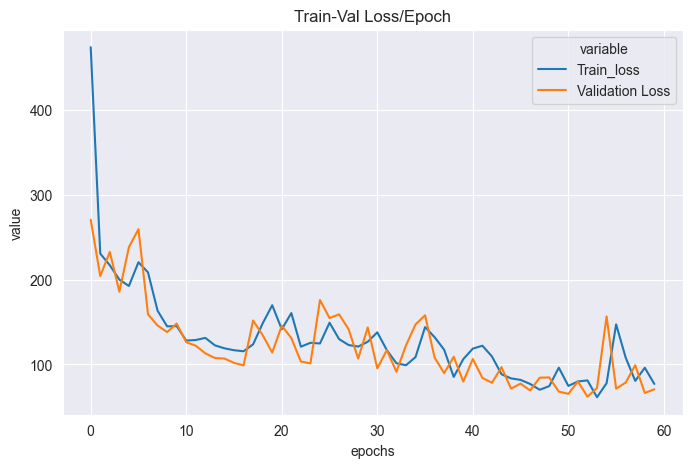

In [232]:
stats_df = pd.DataFrame({'Train_loss': loss_list, 'Validation Loss': val_loss_list})
stats_df_melt = stats_df.reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
print(stats_df_melt['variable'].unique())
stats_df_melt.head()

plt.figure(figsize=(8,5))
sns.lineplot(data=stats_df_melt, x ="epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')
plt.savefig("test.png")
plt.show()

['r2']


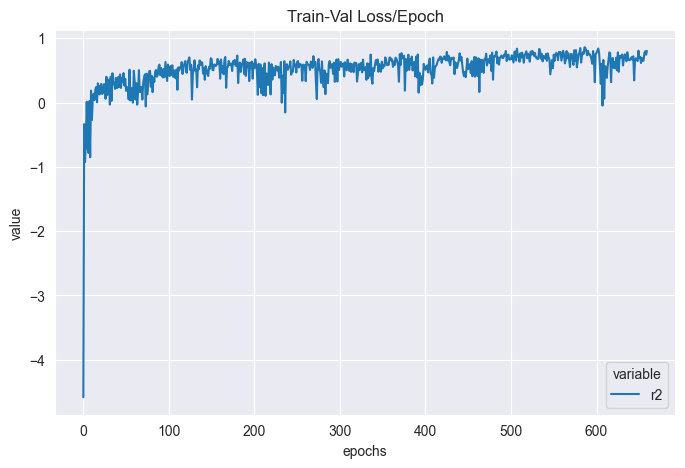

In [234]:
r2_df = pd.DataFrame({'r2': r2_list})
r2_melt = r2_df.reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
print(r2_melt['variable'].unique())

plt.figure(figsize=(8,5))
sns.lineplot(data=r2_melt, x ="epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')
plt.show()

In [235]:
r2_melt

,epochs,variable,value
0,0,r2,-4.583663
1,1,r2,-0.333752
2,2,r2,-0.923878
3,3,r2,-0.564180
4,4,r2,0.014150
...,...,...,...
655,655,r2,0.655816
656,656,r2,0.770977
657,657,r2,0.799988
658,658,r2,0.746216
